Build feature and output arrays

In [37]:
import numpy as np
import pandas as pd
import json

# Listen für alle Daten
all_turbine_types = []
all_hub_heights = []
all_capacities = []
all_commissioning_dates = []
all_production_data = []

# JSON-Datei laden
with open(f"data/WPPs+production+wind.json", "r", encoding="utf-8") as file:
    WPP_production_wind = json.load(file)

# Daten sammeln
for wpp in WPP_production_wind:
    all_turbine_types.append(wpp["Turbine"])
    all_hub_heights.append(wpp["Hub_height"] if not pd.isna(wpp["Hub_height"]) else 100)
    all_capacities.append(wpp["Capacity"])
    all_commissioning_dates.append(wpp["Commission_date"] if wpp["Commission_date"] != "nan" else "2015/06")
    all_production_data.append(wpp["Production"])

turbine_types_set = set(all_turbine_types)

# Alle Werte auf zwei Nachkommastellen runden
all_hub_heights = np.round(all_hub_heights, decimals=2)
all_capacities = np.round(all_capacities, decimals=2)

# NaN-Werte in Turbinentypen durch eindeutige Namen ersetzen
nan_counter = 1
for idx, turbine in enumerate(all_turbine_types):
    if pd.isna(turbine):
        all_turbine_types[idx] = f"nan{nan_counter}"
        nan_counter += 1

# convert E92/2350 format to E-92/2350 format
all_turbine_types = [f"E-{turbine[1:]}" if turbine.startswith("E") and not turbine.startswith("E-") else turbine for turbine in all_turbine_types]

# Datumsformat korrigieren
all_commissioning_dates = [
    "2015/06" if date == "nan" else f"{date}/06" if isinstance(date, str) and "/" not in date else date
    for date in all_commissioning_dates
]

# In datetime konvertieren
standardised_dates = pd.to_datetime(all_commissioning_dates, format='%Y/%m')

# Berechnung des Alters
current_date = pd.Timestamp("2024-12-01")
ages = current_date.year * 12 + current_date.month - (standardised_dates.year * 12 + standardised_dates.month)

# Kombinierte Features und Outputs erstellen
combined_features_raw = []
output_raw = []

# Daten in Feature-Arrays konvertieren
for idx, production_data in enumerate(all_production_data):
    num_rows = len(production_data)

    # Wiederholungen für allgemeine Features
    turbine_type_repeated = np.full((num_rows, 1), all_turbine_types[idx])
    hub_height_repeated = np.full((num_rows, 1), all_hub_heights[idx])
    capacity_repeated = np.full((num_rows, 1), all_capacities[idx])
    age_repeated = np.full((num_rows, 1), ages[idx])

    # Extrahiere Produktionswerte und Windgeschwindigkeiten
    production_values = np.array([entry[1] for entry in production_data]).reshape(-1, 1)
    wind_speeds = np.array([entry[2] for entry in production_data]).reshape(-1, 1)

    wind_speeds = np.round(wind_speeds, decimals=2)

    import pandas as pd

    # Kombinieren in DataFrame, da ohne dtype-Konvertierung möglich (bei numpy arrays muss niedrigster gemeinsamer Datentyp gewählt werden, was string wäre wegen turbine_type_repeated)
    combined_chunk = pd.concat([
        pd.DataFrame(turbine_type_repeated, columns=["Turbine_Type"]),
        pd.DataFrame(hub_height_repeated, columns=["Hub_Height"]),
        pd.DataFrame(capacity_repeated, columns=["Capacity"]),
        pd.DataFrame(age_repeated, columns=["Age"]),
        pd.DataFrame(wind_speeds, columns=["Wind_Speed"])
    ], axis=1)

    # Füge die Daten hinzu
    combined_features_raw.append(combined_chunk)
    output_raw.append(production_values)

# Kombinieren aller Datensätze in einem großen Array
combined_features_raw = np.vstack(combined_features_raw)
output_raw = np.vstack(output_raw)
output_raw = np.round(output_raw, decimals=2)

Extract subset of data for setup of benchmarking test (random sampling)

In [44]:
import numpy as np

num_samples = 100000
random_indices = np.random.choice(combined_features_raw.shape[0], num_samples, replace=False)

combined_features_subset = combined_features_raw[random_indices].copy()
output_subset = output_raw[random_indices].copy()

Extract relevant features

In [52]:
wind_speeds_data = combined_features_subset[:, -1]
capacities = combined_features_subset[:, -3]
turbine_types = combined_features_subset[:, 0]
actual_power_output = output_subset.flatten()

<h1>1. All power curves from The Wind Power that are available

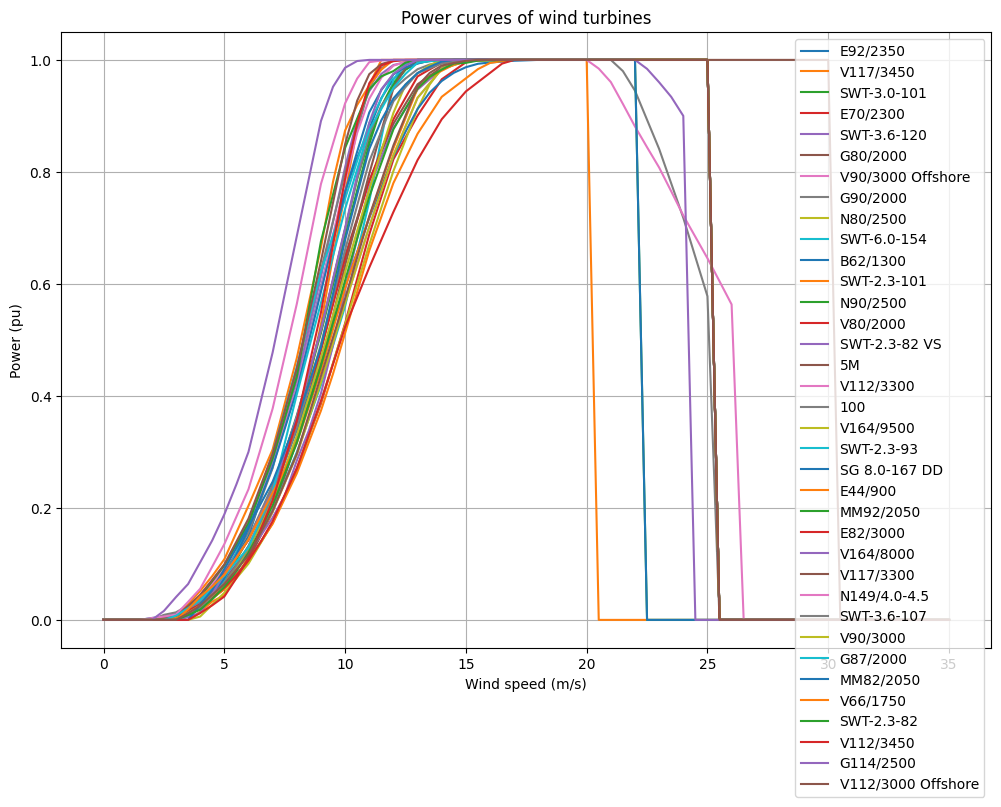

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



file_path_json = r"C:\Users\alexa\Documents\Webapp\data\power_curves.json"

with open(file_path_json, 'r', encoding='utf-16') as file:
    # Zeilenweise die Inhalte als Python-Listen parsen
    data_raw = [eval(line.strip()) for line in file]

# Extrahieren von wind_speed und power
wind_speeds_extracted = [float(item[0]) for item in data_raw]
powers_extracted = [item[1] for item in data_raw]



# assignment of power curve to turbine type
file_path_excel = r"C:\Users\alexa\Documents\Webapp\data\turbine_data.xlsx"
excel_data = pd.read_excel(file_path_excel, sheet_name='Turbine Types')

# Create a mask for non-empty values in the "The Wind Power" column
power_curve_available = excel_data['The Wind Power'].notna()

# Extract the turbine types with power curves in The Wind Power
turbine_types_with_power_curve = np.array(excel_data['Turbine Types'][power_curve_available])



# Extraction of the power curves
power_curves_individual = []
j = 0
i = 0
while j < len(wind_speeds_extracted):
    if wind_speeds_extracted[j] == 0:
        power_curves_individual.append([[], []])
        i += 1
    power_curves_individual[i-1][0].append(wind_speeds_extracted[j])
    power_curves_individual[i-1][1].append(powers_extracted[j])
    j += 1

# Default power curve is that of SWT-3.6-107
for i in range(len(turbine_types_with_power_curve)):
    if turbine_types_with_power_curve[i] == 'SWT-3.6-107':
        default_power_curve = power_curves_individual[i]

# Plot of the power curves
plt.figure(figsize=(12, 8))
for i, power_curve in enumerate(power_curves_individual):
    plt.plot(np.array(power_curve[0]), np.array(power_curve[1]) / max(power_curve[1]), label=turbine_types_with_power_curve[i])

plt.xlabel('Wind speed (m/s)')
plt.ylabel('Power (pu)')
plt.title('Power curves of wind turbines')
plt.legend()
plt.grid(True)
plt.show()

Interpolation

In [47]:
from scipy.interpolate import interp1d

predicted_power_output_1 = []

# Iteration über alle Datenpunkte
for i, (turbine_type, wind_speed, capacity) in enumerate(zip(turbine_types, wind_speeds_data, capacities)):

    if turbine_type in turbine_types_with_power_curve:
        power_curve = power_curves_individual[list(turbine_types_with_power_curve).index(turbine_type)]
        interpolation_function = interp1d(
            np.array(power_curve[0]),
            np.array(power_curve[1]) / max(power_curve[1]),
            kind='cubic',
            fill_value=0 # set values outside the range to 0
        )
    else:
        interpolation_function = interp1d(
            np.array(default_power_curve[0]),
            np.array(default_power_curve[1]) / max(default_power_curve[1]),
            kind='cubic',
            fill_value=0 # set values outside the range to 0
        )
    
    # Vorhergesagten Wert berechnen
    predicted_power_output_1.append(interpolation_function(wind_speed) * capacity)

predicted_power_output_1 = np.array(predicted_power_output_1)

<h1>2. One representative power curve (SWT-3.6-107)

C:\Users\alexa\AppData\Local\Temp\ipykernel_32788\3942985287.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


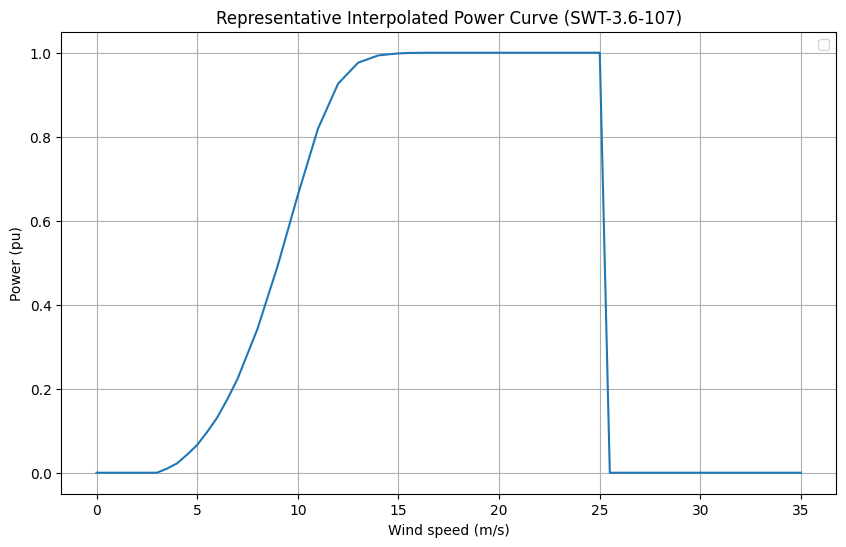

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Plot der diskreten und interpolierten Power Curve
plt.figure(figsize=(10, 6))
plt.plot(np.array(default_power_curve[0]), np.array(default_power_curve[1]) / max(default_power_curve[1]))
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Power (pu)')
plt.title('Representative Interpolated Power Curve (SWT-3.6-107)')
plt.legend()
plt.grid(True)
plt.show()

Interpolation

In [92]:
from scipy.interpolate import interp1d

# Erstelle die Interpolationsfunktion
interpolation_function = interp1d(
    np.array(default_power_curve[0]),
    np.array(default_power_curve[1]) / max(default_power_curve[1]),
    kind='cubic',
    fill_value=0 # set values outside the range to 0
)

# Ensure wind_speeds_data is a numeric array: convert float elements to np.float64 elements
wind_speeds_data = wind_speeds_data.astype(float)

predicted_power_output_2 = interpolation_function(wind_speeds_data) * capacities

<h1>3. Power curves from windpowerlib with a default turbine where no power curve available

c:\Users\alexa\anaconda3\envs\webapp_env_conda\Lib\site-packages\windpowerlib\data.py:103: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ).fillna(False)


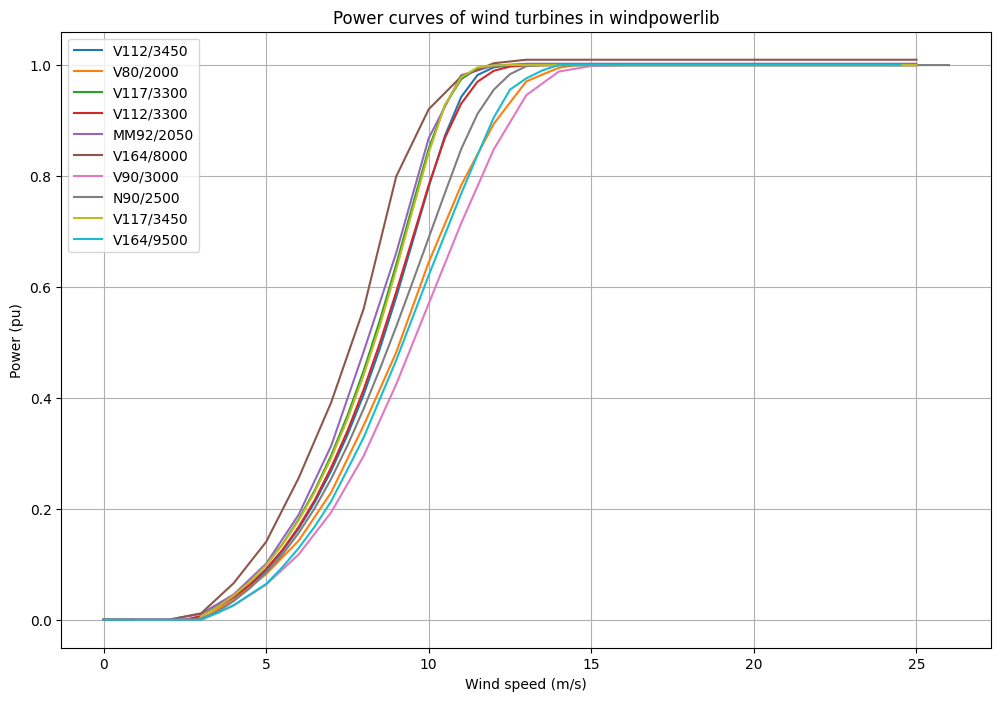

In [55]:
from windpowerlib import WindTurbine
from windpowerlib import data as wt
import matplotlib.pyplot as plt

# Turbinendaten abrufen
turbine_data = wt.get_turbine_types(print_out=False)

# Liste zum Speichern der erstellten WindTurbine-Objekte
wind_turbines = []
wind_turbines_names = []

# Schleife über alle Turbinentypen im Set
for turbine_type in turbine_types_set:
    # Prüfen, ob der Turbinentyp in den Daten existiert
    if turbine_type in turbine_data['turbine_type'].values:
        
        hub_height = 100  # Nabenhöhe irrelevant für power curve
        
        # Definition des WindTurbine-Dictionaries
        turbine_dict = {
            'turbine_type': turbine_type,
            'hub_height': hub_height
        }
        
        # Dynamische Erstellung des WindTurbine-Objekts
        wind_turbine = WindTurbine(**turbine_dict)
        
        # Hinzufügen zur Liste
        wind_turbines.append(wind_turbine)
        wind_turbines_names.append(turbine_type)

# Plot der Power Curves
plt.figure(figsize=(12, 8))
for turbine in wind_turbines:
    if turbine.power_curve is not None:
        plt.plot(turbine.power_curve['wind_speed'], turbine.power_curve['value'] / turbine.nominal_power,
                 label=turbine.turbine_type)

plt.xlabel('Wind speed (m/s)')
plt.ylabel('Power (pu)')
plt.title('Power curves of wind turbines in windpowerlib')
plt.legend()
plt.grid(True)
plt.show()

Interpolation

In [56]:
from scipy.interpolate import interp1d

# after analysis of plot
default_turbine_windpowerlib = next(turbine for turbine in wind_turbines if turbine.turbine_type == "N90/2500")
wind_speed_max = 25

predicted_power_output_3 = []

# Iteration über alle Datenpunkte
for i, (turbine_type, wind_speed, capacity) in enumerate(zip(turbine_types, wind_speeds_data, capacities)):

    if turbine_type in wind_turbines_names:
        turbine = wind_turbines[wind_turbines_names.index(turbine_type)]
    else:
        turbine = default_turbine_windpowerlib

    # Erstelle eine Interpolationsfunktion für die Power Curve dieser Turbine
    interpolation_function = interp1d(
        turbine.power_curve['wind_speed'],
        turbine.power_curve['value'] / turbine.nominal_power,
        kind='cubic',
        fill_value=0 # set values outside the range to 0
    )
    
    # Vorhergesagten Wert berechnen
    predicted_power_output_3.append(interpolation_function(wind_speed) * capacity)

predicted_power_output_3 = np.array(predicted_power_output_3)

# from diagram
cut_off_speed = 25

# Setze vorhergesagte Leistung auf 0 für Windgeschwindigkeiten über wind_speed_max
predicted_power_output_3[wind_speeds_data > cut_off_speed] = 0

<h1>4. Results

In [90]:
predicted_power_output = predicted_power_output_2

# letzten 20 Datenpunkte als DataFrame drucken
df = pd.DataFrame({
    'Wind speed': wind_speeds_data[-20:],
    'Actual Power Output': actual_power_output[-20:],
    'Predicted Power Output': predicted_power_output[-20:],
    'Capacities': capacities[-20:],
})
print(df)

    Wind speed  Actual Power Output Predicted Power Output Capacities
0        14.67                 1.16             208.486056      209.3
1         8.57                22.04              30.915556       74.0
2         8.80                25.36                  49.25      100.0
3         5.95                19.04              43.318333      329.0
4         8.64                50.94              66.844444      160.0
5         3.19                14.44                    0.0      228.0
6         3.88                 1.31                    2.0       90.0
7         4.92                 1.73               2.776667       42.0
8         4.62                17.40              12.916667      300.0
9         9.96                71.66                 59.475       90.0
10        4.07                 2.77               4.651111      209.3
11        5.16                 6.66                   5.95       90.0
12        5.98                12.43                 21.725      165.0
13        7.40      

Losses

In [91]:
import torch

# Ensure the arrays are of type float
predicted_power_output = predicted_power_output.astype(float)
actual_power_output = actual_power_output.astype(float)

predicted_torch = torch.tensor(predicted_power_output, dtype=torch.float32)
actual_torch = torch.tensor(actual_power_output, dtype=torch.float32)

# Berechne den Huber Loss
huber_loss_fn = torch.nn.HuberLoss()
huber_loss_value = huber_loss_fn(predicted_torch, actual_torch).item()
print(f"Huber Loss: {huber_loss_value:.2f}")

# Berechne den MAE Loss
mae_loss_fn = torch.nn.L1Loss()  # L1 Loss entspricht MAE
mae_loss_value = mae_loss_fn(predicted_torch, actual_torch).item()
print(f"Mean Absolute Error (MAE): {mae_loss_value:.2f} MW")

# Berechne den MSE Loss
mse_loss_fn = torch.nn.MSELoss()
mse_loss_value = mse_loss_fn(predicted_torch, actual_torch).item()
print(f"Mean Squared Error (MSE): {mse_loss_value:.2f} MW²")

Huber Loss: 25.56
Mean Absolute Error (MAE): 26.02 MW
Mean Squared Error (MSE): 2733.61 MW²


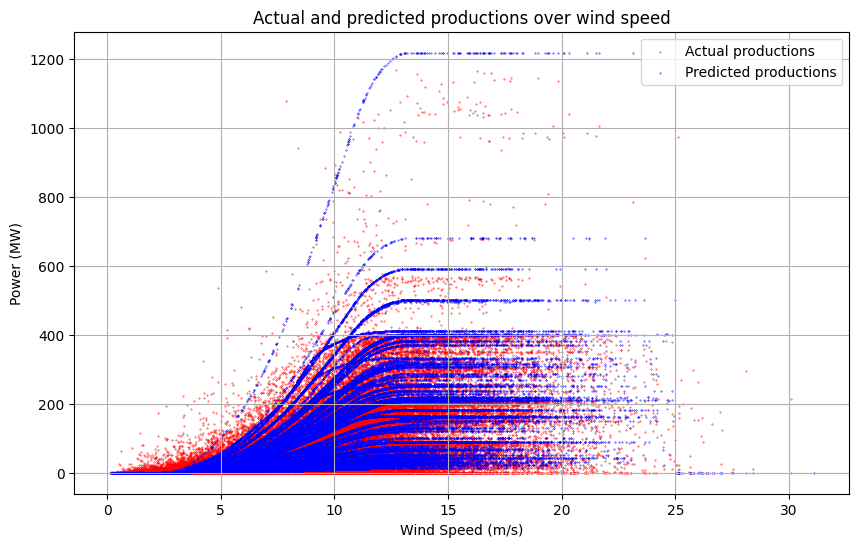

In [80]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(wind_speeds_data, actual_power_output, color='red', s=0.1, label='Actual productions')
plt.scatter(wind_speeds_data, predicted_power_output, color='blue', s=0.1, label='Predicted productions')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power (MW)')
plt.title('Actual and predicted productions over wind speed')
plt.legend()
plt.grid(True)
plt.show()

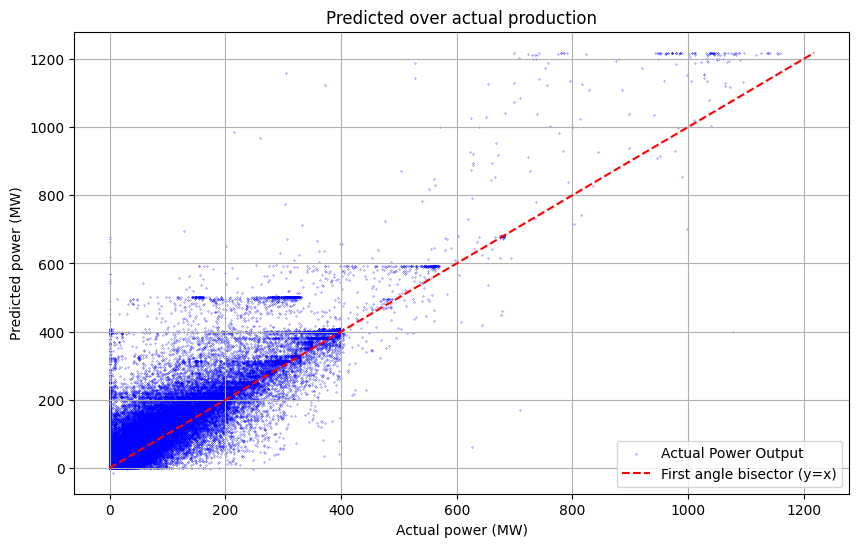

In [290]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(actual_power_output, predicted_power_output, color='blue', s=0.05, label='Actual Power Output')
max_capacity = max(capacities.max(), actual_power_output.max())
plt.plot([0, max_capacity], [0, max_capacity], color='red', linestyle='--', label='First angle bisector (y=x)')
plt.xlabel('Actual power (MW)')
plt.ylabel('Predicted power (MW)')
plt.title('Predicted over actual production')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\alexa\AppData\Local\Temp\ipykernel_32788\2766170251.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


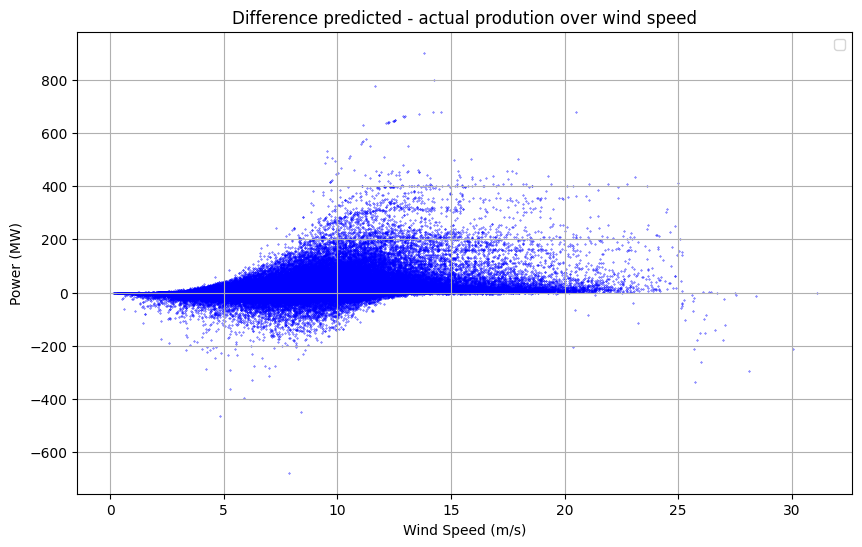

In [73]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(wind_speeds_data, predicted_power_output-actual_power_output, color='blue', s=0.1)
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power (MW)')
plt.title('Difference predicted - actual prodution over wind speed')
plt.legend()
plt.grid(True)
plt.show()

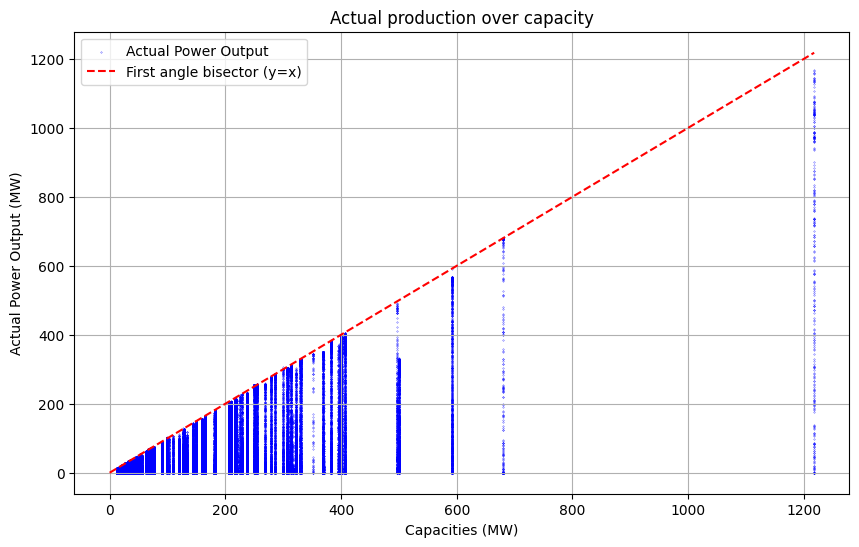

In [72]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(capacities, actual_power_output, color='blue', s=0.05, label='Actual Power Output')
max_capacity = max(capacities.max(), actual_power_output.max())
plt.plot([0, max_capacity], [0, max_capacity], color='red', linestyle='--', label='First angle bisector (y=x)')
plt.xlabel('Capacities (MW)')
plt.ylabel('Actual Power Output (MW)')
plt.title('Actual production over capacity')
plt.legend()
plt.grid(True)
plt.show()